In [1]:
import GPy
import numpy as np
import matplotlib.pyplot as plt
from scipy import io
import pandas as pd
from scipy.stats import chisqprob
import pylab as pb

In [27]:
def build_XI(input_list):
    num_outputs = len(input_list)
    I = np.hstack( [np.repeat(j,_x.shape[0]) for _x,j in zip(input_list,range(num_outputs))] )
    X = np.vstack(input_list)
    X = np.hstack([X,I[:,None]])
    I = {'output_index':I[:,None]}
    return X,I

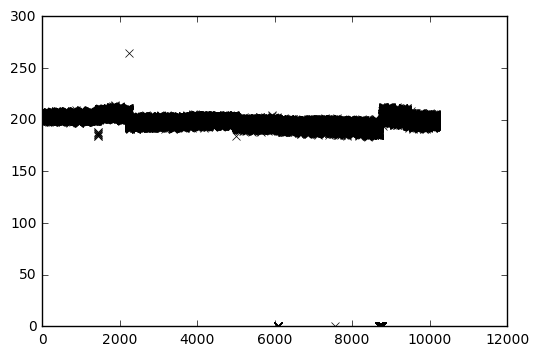

In [22]:
# mat_file1 = io.loadmat('2014_Dataset1.mat')
# t = mat_file1['t']
# p1 = mat_file1['p1']
# p2 = mat_file1['p2']
# x = np.arange(0,len(p2)/10,0.1)[:,None]
# plt.plot(x,p2,'kx')
# plt.show()
# for i in range(len(x)-1):
#     if p2[i]<190:
#         print (i)

mat_file1 = pd.read_csv('dataset 5211.csv')
p1 = np.array(mat_file1['P1'])[:,None]
p2 = np.array(mat_file1['P2'])[:,None]
x = np.arange(0,len(p2)/10,0.1)[:,None]
for i in range(len(p2)):
    if p2[i]<5:
        p2[i] = p2[i]*100
plt.plot(x[0:101682],p2[0:101682],'kx')
# plt.plot(x[Mon[1]:Mon[2]],p2[Mon[1]:Mon[2]],'kx')
plt.show()

In [23]:
Month = []
for i in range(len(mat_file1)):
    if mat_file1['Day'][i] == 1 and mat_file1['Hour'][i] == 0 and mat_file1['Minute'][i]==0:
        Month.append(i)
Mon = list(Month)[0:10]+[86897]+[92773]+[Month[11]]
mat_file1.loc[Mon,:]

,HISTID,Year,Month,Day,Hour,Minute,P1,P2
0,5211,2014,1,1,0,0,5.941,200.854
8928,5211,2014,2,1,0,0,5.972,201.404
16992,5211,2014,3,1,0,0,5.999,204.333
25914,5211,2014,4,1,0,0,6.067,197.742
34551,5211,2014,5,1,0,0,6.121,198.291
43472,5211,2014,6,1,0,0,6.155,201.404
52108,5211,2014,7,1,0,0,6.088,197.376
61036,5211,2014,8,1,0,0,6.067,195.362
69964,5211,2014,9,1,0,0,6.155,195.911
78343,5211,2014,10,1,0,0,6.042,193.348


Initial threshold : {'up': 3.429791666666631, 'down': -4.3103333333332898}
Number of peaks : {'down': 37, 'up': 37}
Grimshaw maximum log-likelihood estimation ... [done]
	          Parameters               Upper               Lower
	------------------------------------------------------------
	                   γ               -0.31               -0.45
	                   σ                0.39                0.51
	          likelihood                9.57                4.42
	    Extreme quantile                3.42               -4.30
	------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████| 99682/99682 [00:01<00:00, 84466.44it/s]


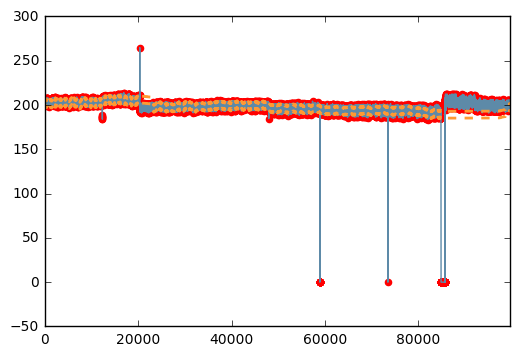

In [16]:
from spot import bidSPOT
q = 0.02 				# risk parameter
d = 120  				# depth parameter
s = bidSPOT(q,d) 

X = p2[0:]
X = np.reshape(X,(1,len(X))).flatten()
n_init = 2000
init_data = X[:n_init] 	# initial batch
data = X[n_init:] 
s.fit(init_data,data) 	# data import
s.initialize() 	  		# initialization step
results = s.run()    	# run
s.plot(results)

# plt.xlim([7070,7220])
# plt.ylim([180,245])
plt.show()

In [17]:
a = results['alarms']
al = np.array(a) +2000
spot_m = np.zeros(12)
for i in range(len(al)):
    for j in range(len(Mon)-1):
        if Mon[j] <= al[i] <= Mon[j+1]:
            spot_m[j] += 1
        else:
            pass    

In [2]:
import pickle
f = open('d:/hyperparameter1_4500','rb')
gp = pickle.load(f)
f.close()

In [7]:
def plot_2outputs(m,xlim,x_1,x_2):
    fig = pb.figure(figsize=(12,8))
    fig.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
    plt.grid(False)
    
    plt.xlabel('X',fontsize=16)
    plt.ylabel('Y',fontsize=16)
    #Output 1
    ax1 = fig.add_subplot(211)
    ax1.set_xlim(xlim)
    ax1.set_title('Output 1')
    m.plot(plot_limits=xlim,fixed_inputs=[(1,0)],which_data_rows=slice(0,len(x_1)),ax=ax1)
    ax1.legend(loc=3)

    #Output 2
    ax2 = fig.add_subplot(212)
    ax2.set_xlim(xlim)
    ax2.set_title('Output 2')
    m.plot(plot_limits=xlim,fixed_inputs=[(1,1)],which_data_rows=slice(len(x_1),len(x_1)+len(x_2)),ax=ax2)
    ax2.legend(loc=3)

# EVT-GP


In [25]:
def rbf(X,xt,m):
    Xt = xt*np.ones(len(X))[:,None]
    k = ((X-Xt)**2)/(2*(2*m.kern.ICM0.rbf.lengthscale[0])**2)
    ke = np.exp(-k)
    n = np.sum(ke)
    return n

def z_score(n):
    alpha = (2*np.log(n))**(-0.5)
    beta = (2*np.log(n))**(0.5) - (np.log(np.log(n))+np.log(2*np.pi))/(2*(2*np.log(n))**0.5)
    zp = beta-alpha*np.log(-np.log(0.98))
    return zp

def Mahalanobis_distance(model,x_test,y2):
    X,I = build_XI([x_test,x_test])
    mean, variance = model.predict(X, full_cov=True, Y_metadata=I)
    l = len(x_test)
    MD2 = np.dot(np.dot(np.transpose(y2-mean[l:2*l]),np.linalg.inv(variance[l:2*l,l:2*l])),y2-mean[l:2*l])

    return MD2

kern = gp.kern.copy()

In [37]:
s = Mon[7]
l = 120

it = list(range(s,s+l))
kt = it.copy()
anomal_points = []
test_points = []
test_points2 = []
chi_sq = []
con_bd = []
step = 1

for i in range(Mon[8]-Mon[7]-l):
    # 기존 100개 model에 z 구하기
    new = it[len(it)-1]+step
    test_points.append(new)
    
    mul = GPy.models.GPCoregionalizedRegression([x[kt],x[it]],[p1[kt],p2[it]],kernel = kern)
    mul['.*Gaussian_noise_0.variance'].constrain_fixed(gp.mixed_noise.Gaussian_noise_0.variance)
    mul['.*Gaussian_noise_1.variance'].constrain_fixed(gp.mixed_noise.Gaussian_noise_1.variance)
    
    print(new)
    # pointwise detection
   
    test_x = x[new]
    n = rbf(x[it],test_x,mul)
    zp = z_score(n)

    # 벗어나는 x찾기
    jt = it + list([new])
    X,I = build_XI([x[jt],x[jt]])
    mu,var = mul.predict(X,Y_metadata=I,kern=mul.kern,likelihood=mul.likelihood)
    mu2 = mu[int(len(mu)/2):len(mu)]
    var2 = var[int(len(mu)/2):len(mu)]
    
    con_ue = mu2 + np.sqrt(var2)*zp
    con_le = mu2 - np.sqrt(var2)*zp

    if i == 0:
        for j in range(len(con_ue)):
            con_bd.append([con_ue[j],con_le[j]])
            test_points2.append([jt[j],jt[j]])
    else:
        con_bd.append([con_ue[len(con_ue)-1],con_le[len(con_le)-1]])
        test_points2.append([new,new])
  
    if p2[new] > mu2[l] + zp*np.sqrt(var2[l]) or p2[new] < mu2[l] - zp*np.sqrt(var2[l]):
        anomal_points.append(new)
        it = it
        kt = kt + list([new])
        step += 1
    else:
        it.pop(0)
        it = it + list([new])
        kt.pop(0)
        kt = kt + list([new])
        step = 1
        
    # trajectory detection    
    
    mul2 = GPy.models.GPCoregionalizedRegression([x[kt],x[it[0:len(it)-12]]],[p1[kt],p2[it[0:len(it)-12]]],kernel = kern)
    mul2['.*Gaussian_noise_0.variance'].constrain_fixed(gp.mixed_noise.Gaussian_noise_0.variance)
    mul2['.*Gaussian_noise_1.variance'].constrain_fixed(gp.mixed_noise.Gaussian_noise_1.variance)
    
    ct = it[len(it)-12:len(it)]
    md2 = Mahalanobis_distance(mul2,x[ct],p2[ct])
    cs = chisqprob(md2,len(ct))[0][0]
    chi_sq.append(cs)
#     if cs <0.02:
#         plot_2outputs(mul2, xlim=(x[kt[0]],x[kt[len(kt)-1]]),x_1=x[kt],x_2=x[it[0:len(it)-20]])
#         plt.plot(x[ct],p2[ct],'kx')
#         plt.show()


# s = Mon[0]
# l = 120

# it = list(range(s,s+l))
# anomal_points = []
# test_points = []
# test_points2 = []
# chi_sq = []
# con_bd = []
# step = 1

# for i in range(Mon[1]-Mon[0]-l):
#     # 기존 100개 model에 z 구하기
#     new = it[len(it)-1]+step
#     test_points.append(new)
    
#     mul = GPy.models.GPCoregionalizedRegression([x[it],x[it]],[p1[it],p2[it]],kernel = kern)
#     mul['.*Gaussian_noise_0.variance'].constrain_fixed(gp.mixed_noise.Gaussian_noise_0.variance)
#     mul['.*Gaussian_noise_1.variance'].constrain_fixed(gp.mixed_noise.Gaussian_noise_1.variance)
    
#     print(new)
#     # pointwise detection
   
#     test_x = x[new]
#     n = rbf(x[it],test_x,mul)
#     zp = z_score(n)

#     # 벗어나는 x찾기
#     jt = it + list([new])
#     X,I = build_XI([x[jt],x[jt]])
#     mu,var = mul.predict(X,Y_metadata=I,kern=mul.kern,likelihood=mul.likelihood)
#     mu2 = mu[int(len(mu)/2):len(mu)]
#     var2 = var[int(len(mu)/2):len(mu)]
    
#     con_ue = mu2 + np.sqrt(var2)*zp
#     con_le = mu2 - np.sqrt(var2)*zp

#     if i == 0:
#         for j in range(len(con_ue)):
#             con_bd.append([con_ue[j],con_le[j]])
#             test_points2.append([jt[j],jt[j]])
#     else:
#         con_bd.append([con_ue[len(con_ue)-1],con_le[len(con_le)-1]])
#         test_points2.append([new,new])
  
#     if p2[new] > mu2[l] + zp*np.sqrt(var2[l]) or p2[new] < mu2[l] - zp*np.sqrt(var2[l]):
#         plot_2outputs(mul, xlim=(x[it[0]],x[it[len(it)-1]+2]),x_1=x[it],x_2=x[it])
#         plt.plot(x[new],p2[new],'kx')
#         plt.plot(x[new],mu2[l],'rx')
#         plt.show()
        
#         anomal_points.append(new)
#         p2[new] = mu2[l]
        
#     else:
#         it.pop(0)
#         it = it + list([new])
#         step = 1
        
#     # trajectory detection    
    
#     mul2 = GPy.models.GPCoregionalizedRegression([x[it],x[it[0:len(it)-20]]],[p1[it],p2[it[0:len(it)-20]]],kernel = kern)
#     mul2['.*Gaussian_noise_0.variance'].constrain_fixed(gp.mixed_noise.Gaussian_noise_0.variance)
#     mul2['.*Gaussian_noise_1.variance'].constrain_fixed(gp.mixed_noise.Gaussian_noise_1.variance)
    
#     ct = it[len(it)-20:len(it)]
#     md2 = Mahalanobis_distance(mul2,x[ct],p2[ct])
#     cs = chisqprob(md2,len(ct))[0][0]
#     chi_sq.append(cs)
    


61156


AttributeError: 'NoneType' object has no attribute 'shape'

In [10]:
trend = []

for i in range(len(chi_sq)):
    if chi_sq[i] < 0.02:
        trend.append(test_points[i])
        print(test_points[i])
    
day = []
t_count = 0
for i in range(len(trend)-1):
    if i == 0:
        t_count += 1
    else:
        if trend[i]-trend[i-1]<6:
            pass
        else:
            if trend[i+1]-trend[i] <6:
                print(trend[i])
                t_count += 1

print(len(anomal_points),t_count)

61159
61169
61170
61171
61180
61198
61199
61200
61201
61202
61203
61204
61205
61206
61207
61208
61209
61210
61211
61212
61213
61214
61215
61216
61217
61219
61270
61271
61272
61284
61286
61289
61290
61291
61292
61293
61294
61298
61299
61300
61302
61303
61304
61305
61306
61307
61308
61309
61310
61311
61312
61313
61314
61315
61316
61317
61318
61319
61320
61321
61322
61323
61324
61325
61326
61327
61328
61329
61330
61331
61332
61333
61334
61335
61336
61370
61371
61372
61373
61374
61375
61376
61377
61378
61379
61380
61381
61382
61383
61384
61385
61386
61387
61388
61389
61390
61391
61392
61393
61394
61395
61396
61398
61399
61400
61401
61402
61403
61404
61407
61408
61409
61410
61411
61412
61413
61414
61415
61416
61417
61418
61419
61421
61422
61423
61424
61428
61429
61430
61434
61435
61436
61437
61438
61439
61440
61441
61442
61443
61444
61445
61446
61447
61448
61449
61450
61451
61452
61453
61454
61455
61456
61457
61458
61459
61460
61461
61462
61476
61477
61478
61479
61480
61481
61482
61483
6148

In [74]:
from collections import Counter

a = Counter(day)
df = pd.DataFrame.from_dict(a, orient='index').reset_index()
df = df.rename(columns={'index':'day', 0:'count'})

df.to_csv('point.csv',index=False)

b = Counter(day_p)
df2 = pd.DataFrame.from_dict(b, orient='index').reset_index()
df2 = df.rename(columns={'index':'day', 0:'count'})
df2.to_csv('trend.csv',index=False)
# Counter(day_p)

In [75]:
Counter(day_p)

Counter({1: 4,
         2: 1,
         4: 1,
         7: 7,
         8: 1,
         9: 2,
         11: 1,
         13: 1,
         14: 3,
         15: 1,
         16: 2,
         20: 1,
         22: 1,
         23: 2,
         25: 1,
         31: 9,
         33: 1,
         34: 2,
         42: 3,
         43: 1,
         44: 1,
         45: 1,
         47: 1,
         48: 2,
         50: 3,
         53: 1,
         59: 12})

In [32]:
f = (np.array(test_points2)[:,0]/10)[:,None][:,0]
c1 = (np.array(con_bd)[:,0])[:,0]
c2 = (np.array(con_bd)[:,1])[:,0]

 C:\Users\Woojin Cho\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:531: UserWarning:No labelled objects found. Use label='...' kwarg on individual plots.


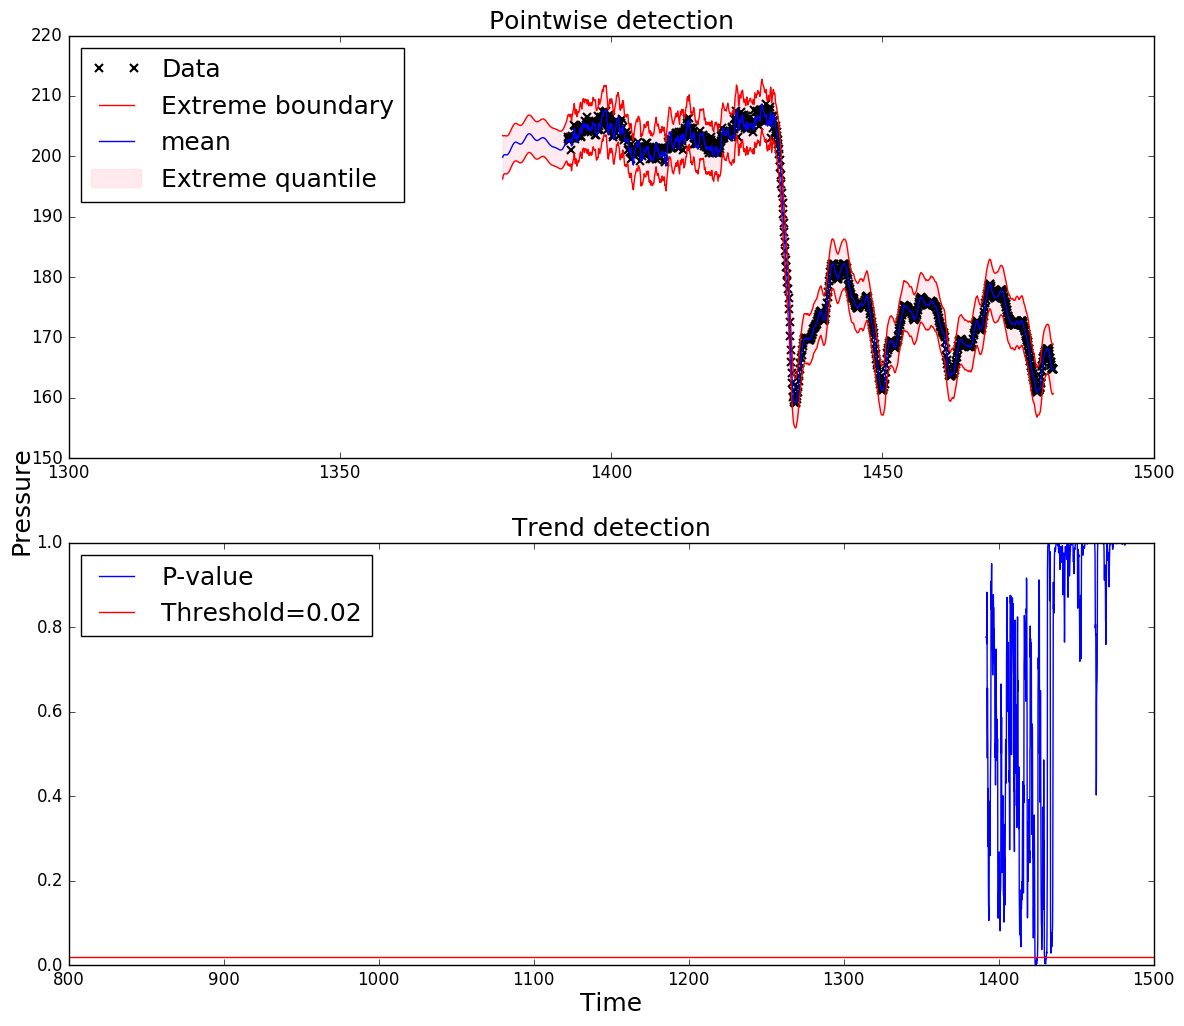

In [33]:
fig = pb.figure(figsize=(14,12))
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
plt.grid(False)
    
plt.xlabel('Time',fontsize=18)
plt.ylabel('Pressure',fontsize=18)
#Output 1
ax1 = fig.add_subplot(211)
ax1.set_xlim([1300,1500])
ax1.set_title('Pointwise detection',fontsize=18)
ax1.tick_params(labelsize=12)
ax1.plot(x[test_points],p2[test_points],'kx',mew = 1.5,label="Data")
ax1.plot(np.array(test_points2)[:,0]/10,np.array(con_bd)[:,0],color='red',label="Extreme boundary")
ax1.plot(np.array(test_points2)[:,1]/10,np.array(con_bd)[:,1],color='red')
ax1.fill_between(f, c1, c2, color='pink', alpha=0.3,label="Extreme quantile")
ax1.plot(np.array(test_points2)[:,1]/10,(c1+c2)/2,color='blue',label="mean")
ax1.legend(loc=2,fontsize=18)
# ax1.annotate('anomal points', xy=(911.9, 186), xytext=(910.3, 185), fontsize = 15, arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"))

#Output 2
ax2 = fig.add_subplot(212)
ax2.set_xlim([800,1500])
ax2.set_ylim([0,1])
ax2.set_title('Trend detection',fontsize=18)
ax2.tick_params(labelsize=12)
ax2.legend(loc=3)
ax2.plot(x[test_points],chi_sq,label="P-value")
a = np.linspace(800,1500,100)
th = 0.02*np.ones(a.shape)
ax2.plot(a,th,color='red',label="Threshold=0.02")
ax2.legend(loc=2,fontsize=18)
# ax2.annotate('trend anomaly', xy=(911.1, 0.03), xytext=(912, 0.1), fontsize = 15, arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"))
fig.savefig('1.png')
plt.show()